<a href="https://colab.research.google.com/github/Praful22/AdaptiveControl/blob/main/AdaptiveControl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

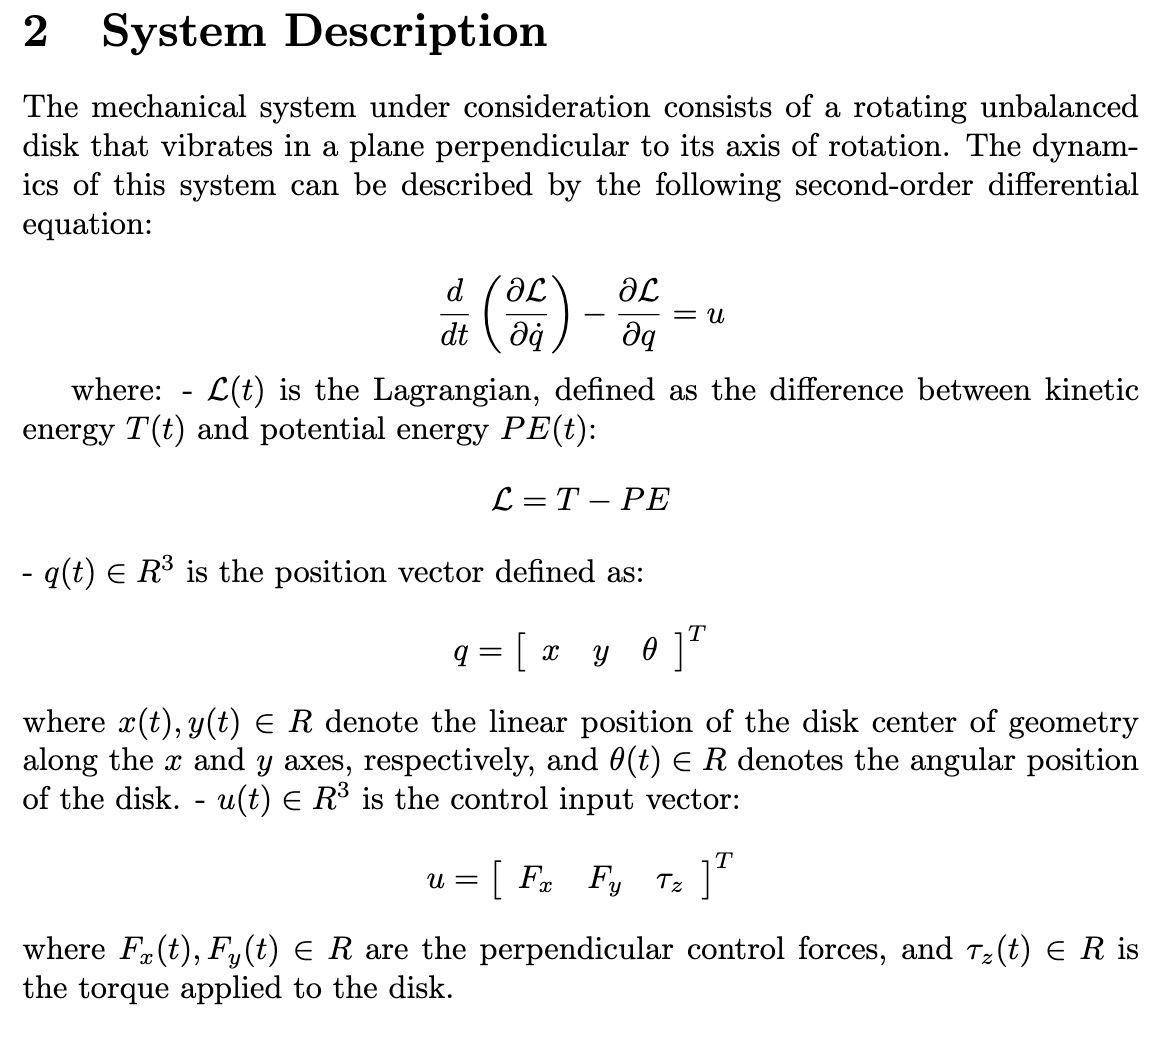
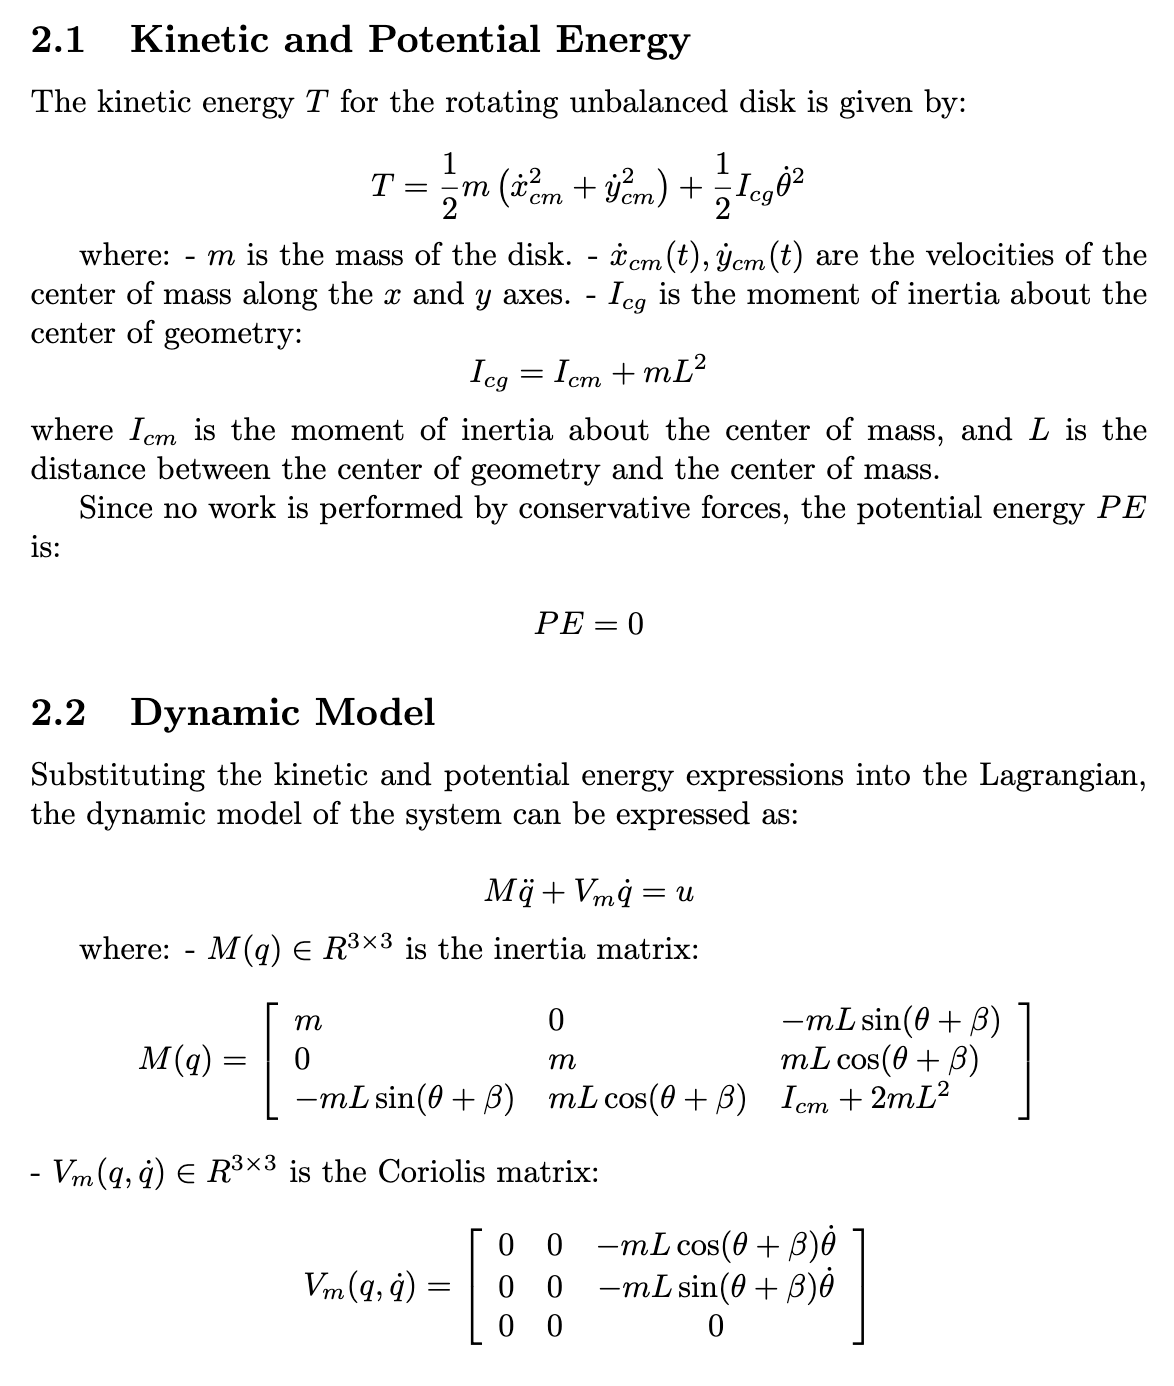

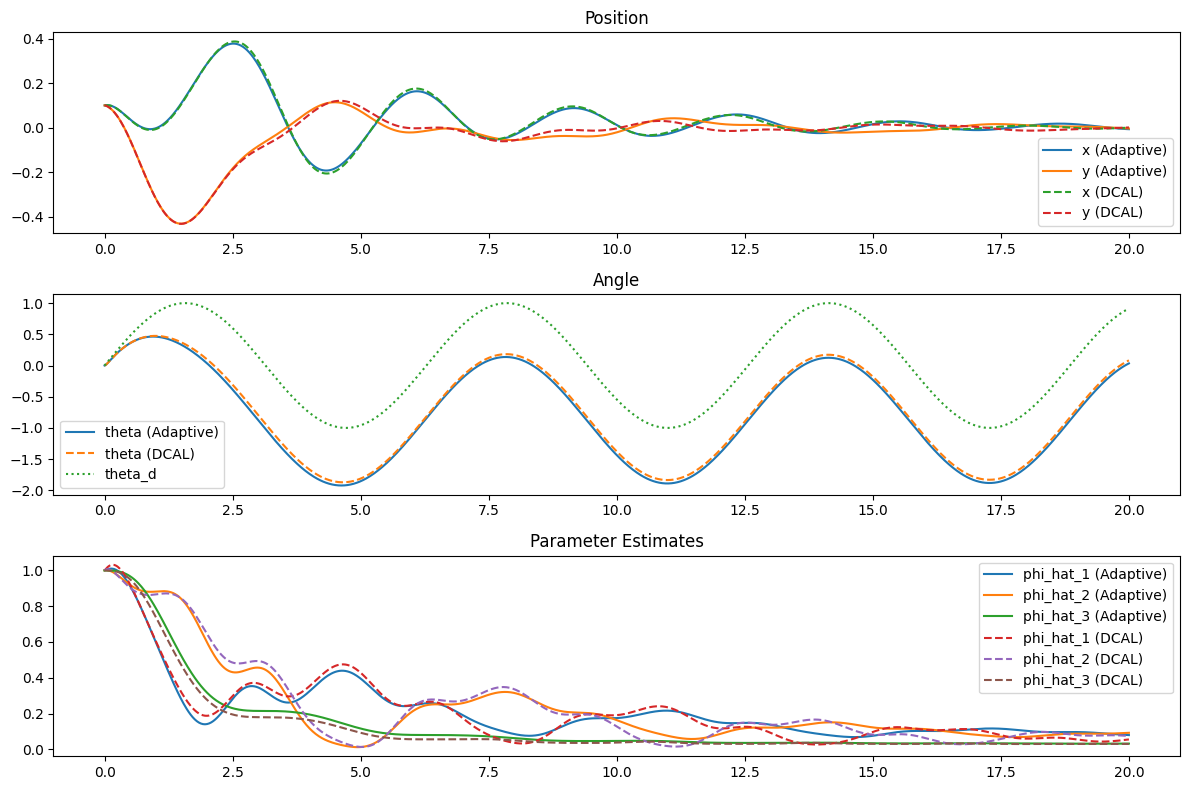

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

class AutobalancingSystem:
    def __init__(self, m, L, I_cg, beta, alpha1, alpha2, k_p1, k_p2,
                 k_s1, k_s2, k_s3, k_n, lambda1, k1, zeta1, gamma):
        self.m = m  # mass of the disk
        self.L = L  # distance between center of geometry and center of mass
        self.I_cg = I_cg  # moment of inertia about center of geometry
        self.beta = beta  # initial angle subtended by L with positive x axis
        self.alpha1 = alpha1  # control gain
        self.alpha2 = alpha2  # control gain
        self.k_p1 = k_p1  # control gain
        self.k_p2 = k_p2  # control gain
        self.K_s = np.diag([k_s1, k_s2, k_s3])  # control gain matrix
        self.k_n = k_n  # control gain
        self.lambda1 = lambda1  # forgetting factor parameter
        self.k1 = k1  # gain matrix bound
        self.zeta1 = zeta1  # bounding constant
        self.gamma = gamma  # filter parameter

    def M(self, q):
        theta = q[2]
        return np.array([
            [self.m, 0, -self.m * self.L * np.sin(theta + self.beta)],
            [0, self.m, self.m * self.L * np.cos(theta + self.beta)],
            [-self.m * self.L * np.sin(theta + self.beta), self.m * self.L * np.cos(theta + self.beta), self.I_cg + 2 * self.m * self.L**2]
        ])

    def V_m(self, q, q_dot):
        theta = q[2]
        theta_dot = q_dot[2]
        return np.array([
            [0, 0, -self.m * self.L * np.cos(theta + self.beta) * theta_dot],
            [0, 0, -self.m * self.L * np.sin(theta + self.beta) * theta_dot],
            [0, 0, 0]
        ])

    def Y_d(self, q, theta_d_dot, theta_d_ddot):
        theta = q[2]
        return np.array([
            [-np.sin(theta) * theta_d_ddot - np.cos(theta) * theta_d_dot**2, -np.cos(theta) * theta_d_ddot + np.sin(theta) * theta_d_dot**2, 0],
            [np.cos(theta) * theta_d_ddot - np.sin(theta) * theta_d_dot**2, -np.sin(theta) * theta_d_ddot - np.cos(theta) * theta_d_dot**2, 0],
            [0, 0, theta_d_ddot]
        ])

    def adaptive_control(self, t, state, theta_d, theta_d_dot, theta_d_ddot):
        q = state[:3]
        q_dot = state[3:6]
        phi_hat = state[6:]

        r = np.array([
            -q_dot[0] - self.alpha1 * q[0],
            -q_dot[1] - self.alpha2 * q[1],
            theta_d_dot - q_dot[2]
        ])

        Y_d = self.Y_d(q, theta_d_dot, theta_d_ddot)
        u = Y_d @ phi_hat + self.K_s @ r - np.array([self.k_p1 * q[0], self.k_p2 * q[1], 0])

        M = self.M(q)
        V_m = self.V_m(q, q_dot)

        q_ddot = np.linalg.inv(M) @ (u - V_m @ q_dot)

        phi_hat_dot = np.linalg.inv(self.K_s) @ Y_d.T @ r

        return np.concatenate([q_dot, q_ddot, phi_hat_dot])

    def dcal_adaptive_control(self, t, state, theta_d, theta_d_dot, theta_d_ddot):
        q = state[:3]
        q_dot = state[3:6]
        phi_hat = state[6:9]
        P_inv = state[9:18].reshape(3, 3)

        r = np.array([
            -q_dot[0] - self.alpha1 * q[0],
            -q_dot[1] - self.alpha2 * q[1],
            theta_d_dot - q_dot[2]
        ])
        Y_d = self.Y_d(q, theta_d_dot, theta_d_ddot)
        u = Y_d @ phi_hat + self.K_s @ r - np.array([self.k_p1 * q[0],
                                                          self.k_p2 * q[1], 0]) + self.k_n * self.zeta1**2 * r


        Y_df = self.filter_Y_d(Y_d, t)
        u_df = self.filter_u(u, t)

        epsilon = u_df - Y_df @ phi_hat



        M = self.M(q)
        V_m = self.V_m(q, q_dot)

        q_ddot = np.linalg.inv(M) @ (u - V_m @ q_dot)

        P = np.linalg.inv(P_inv)
        phi_hat_dot = P @ (Y_df.T @ epsilon + Y_d.T @ r)

        lambda_t = self.lambda1 / self.k1 * (self.k1 - np.linalg.norm(P, ord=2))
        P_inv_dot = -lambda_t * P_inv + Y_df.T @ Y_df

        return np.concatenate([q_dot, q_ddot, phi_hat_dot, P_inv_dot.flatten()])

    def filter_Y_d(self, Y_d, t):
        return self.gamma * np.exp(-self.gamma * t) * Y_d

    def filter_u(self, u, t):
        return self.gamma * np.exp(-self.gamma * t) * u

    def simulate(self, t_span, initial_state, theta_d_func, theta_d_dot_func,
                 theta_d_ddot_func, method='adaptive'):
        def ode_func(t, state):
            theta_d = theta_d_func(t)
            theta_d_dot = theta_d_dot_func(t)
            theta_d_ddot = theta_d_ddot_func(t)
            if method == 'adaptive':
                return self.adaptive_control(t, state, theta_d,
                                             theta_d_dot, theta_d_ddot)
            elif method == 'dcal':
                return self.dcal_adaptive_control(t, state, theta_d,
                                                  theta_d_dot, theta_d_ddot)

        if method == 'dcal':
            initial_state = np.concatenate([initial_state, np.eye(3).flatten()])

        t_eval = np.linspace(t_span[0], t_span[1], 1000)
        solution = solve_ivp(ode_func, t_span, initial_state,
                             t_eval=t_eval)
        return solution.t, solution.y.T

# Example usage:
if __name__ == "__main__":
    # System parameters
    m = 1.0  # kg
    L = 0.1  # m
    I_cg = 0.01  # kg*m^2
    beta = np.pi/4  # rad

    # Control gains
    alpha1 = 1.0
    alpha2 = 1.0
    k_p1 = 1.0
    k_p2 = 1.0
    k_s1 = 1.0
    k_s2 = 1.0
    k_s3 = 1.0
    k_n = 0.1
    lambda1 = 0.1
    k1 = 10.0
    zeta1 = 0.1
    gamma = 1.0

    system = AutobalancingSystem(m, L, I_cg, beta, alpha1, alpha2, k_p1, k_p2,
                                 k_s1, k_s2, k_s3, k_n, lambda1, k1, zeta1,
                                 gamma)

    # Simulation parameters
    t_span = (0, 20)
    initial_state = np.array([0.1, 0.1, 0, 0, 0, 0, 1, 1, 1])  # [x, y, theta, x_dot, y_dot, theta_dot, phi_hat]

    # Desired trajectory functions
    theta_d_func = lambda t: np.sin(t)
    theta_d_dot_func = lambda t: np.cos(t)
    theta_d_ddot_func = lambda t: -np.sin(t)

    # Run simulation
    t, solution_adaptive = system.simulate(t_span, initial_state, theta_d_func,
                                           theta_d_dot_func, theta_d_ddot_func,
                                           method='adaptive')
    t, solution_dcal = system.simulate(t_span, initial_state, theta_d_func,
                                       theta_d_dot_func, theta_d_ddot_func,
                                       method='dcal')

    # Plot results
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(t, solution_adaptive[:, 0], label='x (Adaptive)')
    plt.plot(t, solution_adaptive[:, 1], label='y (Adaptive)')
    plt.plot(t, solution_dcal[:, 0], label='x (DCAL)', linestyle='--')
    plt.plot(t, solution_dcal[:, 1], label='y (DCAL)', linestyle='--')
    plt.legend()
    plt.title('Position')

    plt.subplot(3, 1, 2)
    plt.plot(t, solution_adaptive[:, 2], label='theta (Adaptive)')
    plt.plot(t, solution_dcal[:, 2], label='theta (DCAL)', linestyle='--')
    plt.plot(t, [theta_d_func(ti) for ti in t], label='theta_d', linestyle=':')
    plt.legend()
    plt.title('Angle')

    plt.subplot(3, 1, 3)
    plt.plot(t, solution_adaptive[:, 6], label='phi_hat_1 (Adaptive)')
    plt.plot(t, solution_adaptive[:, 7], label='phi_hat_2 (Adaptive)')
    plt.plot(t, solution_adaptive[:, 8], label='phi_hat_3 (Adaptive)')
    plt.plot(t, solution_dcal[:, 6], label='phi_hat_1 (DCAL)', linestyle='--')
    plt.plot(t, solution_dcal[:, 7], label='phi_hat_2 (DCAL)', linestyle='--')
    plt.plot(t, solution_dcal[:, 8], label='phi_hat_3 (DCAL)', linestyle='--')
    plt.legend()
    plt.title('Parameter Estimates')

    plt.tight_layout()
    plt.show()
